In [14]:
import numpy as np
import sorting
import time
from matplotlib import pyplot as plt
np.random.seed(42)

In [15]:
MIN_MERGE = 32
 
def calcMinRun(n):
    """Returns the minimum length of a
    run from 23 - 64 so that
    the len(array)/minrun is less than or
    equal to a power of 2.
 
    e.g. 1=>1, ..., 63=>63, 64=>32, 65=>33,
    ..., 127=>64, 128=>32, ...
    """
    r = 0
    while n >= MIN_MERGE:
        r |= n & 1
        n >>= 1
    return n + r
 
 
# This function sorts array from left index to
# to right index which is of size atmost RUN
def insertionSort(arr, left, right):
    for i in range(left + 1, right + 1):
        j = i
        while j > left and arr[j] < arr[j - 1]:
            arr[j], arr[j - 1] = arr[j - 1], arr[j]
            j -= 1
 
 
# Merge function merges the sorted runs
def merge(arr, l, m, r):
     
    # original array is broken in two parts
    # left and right array
    len1, len2 = m - l + 1, r - m
    left, right = [], []
    for i in range(0, len1):
        left.append(arr[l + i])
    for i in range(0, len2):
        right.append(arr[m + 1 + i])
 
    i, j, k = 0, 0, l
     
    # after comparing, we merge those two array
    # in larger sub array
    while i < len1 and j < len2:
        if left[i] <= right[j]:
            arr[k] = left[i]
            i += 1
 
        else:
            arr[k] = right[j]
            j += 1
 
        k += 1
 
    # Copy remaining elements of left, if any
    while i < len1:
        arr[k] = left[i]
        k += 1
        i += 1
 
    # Copy remaining element of right, if any
    while j < len2:
        arr[k] = right[j]
        k += 1
        j += 1
 
 
# Iterative Timsort function to sort the
# array[0...n-1] (similar to merge sort)
def timSort(arr):
    n = len(arr)
    minRun = calcMinRun(n)
     
    # Sort individual subarrays of size RUN
    for start in range(0, n, minRun):
        end = min(start + minRun - 1, n - 1)
        insertionSort(arr, start, end)
 
    # Start merging from size RUN (or 32). It will merge
    # to form size 64, then 128, 256 and so on ....
    size = minRun
    while size < n:
         
        # Pick starting point of left sub array. We
        # are going to merge arr[left..left+size-1]
        # and arr[left+size, left+2*size-1]
        # After every merge, we increase left by 2*size
        for left in range(0, n, 2 * size):
 
            # Find ending point of left sub array
            # mid+1 is starting point of right sub array
            mid = min(n - 1, left + size - 1)
            right = min((left + 2 * size - 1), (n - 1))
 
            # Merge sub array arr[left.....mid] &
            # arr[mid+1....right]
            if mid < right:
                merge(arr, left, mid, right)
 
        size = 2 * size
 

In [16]:
def const_func(v):
    return 42

def sum_func(v):
    return sum(v)

def prod_func(v):
    res = 1
    for i in v:
        res *= i
    return res

def poly_func(v, x):
    import decimal  
    decimal.getcontext().prec = 100
    res = 0
    for i in range(len(v)):
        res += decimal.Decimal(v[i]) * (decimal.Decimal(x) ** i)
    return res

def poly_func_horner(v, x):
    res = x
    for i in range(len(v)-1, 0, -1):
        res = res * v[i] + v[i-1]
    return res

def timsort(v):
    # since standard library's sorted is too fast, use custom implementation from
    # https://www.geeksforgeeks.org/timsort/
    # return sorted(v)
    timSort(v)

def bubblesort(v):
    for i in range(len(v)-1):
        for j in range(0, len(v)-i-1):
            if v[j] > v[j + 1] :
                v[j], v[j + 1] = v[j + 1], v[j]
    return v

def quicksort(v):
    return sorting.quick(v)

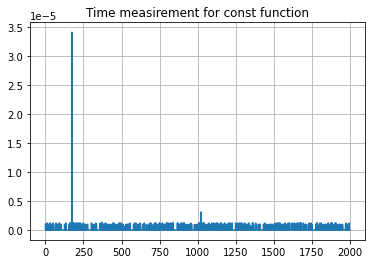

In [17]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    const_func(v)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measirement for const function")
plt.grid(True)
plt.show()

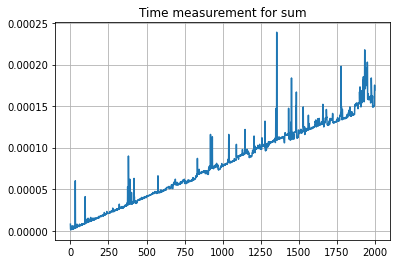

In [18]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    sum_func(v)
    times.append(time.time() - start_time)

plt.plot(times)
plt.grid(True)
plt.title("Time measurement for sum")
plt.show()

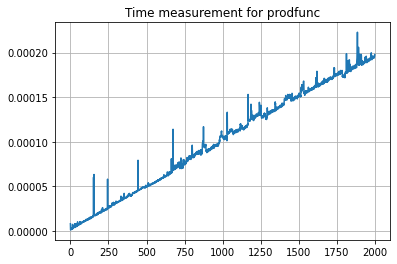

In [19]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    prod_func(v)
    times.append(time.time() - start_time)

plt.grid(True)
plt.plot(times)
plt.title("Time measurement for prodfunc")
plt.show()

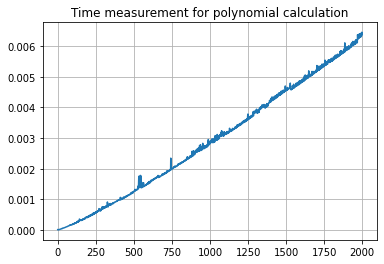

In [20]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    poly_func(v, 1.5)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measurement for polynomial calculation")
plt.grid(True)

plt.show()

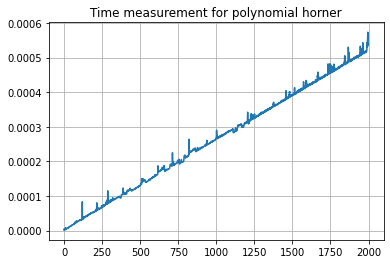

In [21]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    poly_func_horner(v, 1.5)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measurement for polynomial horner")
plt.grid(True)

plt.show()

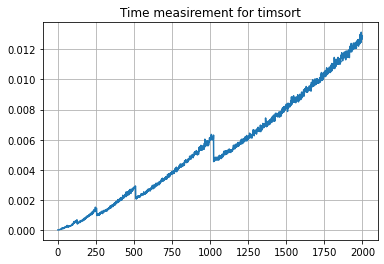

In [22]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    timsort(v)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measirement for timsort")
plt.grid(True)
plt.show()

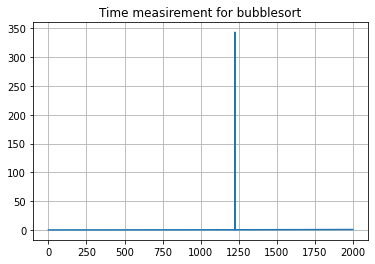

In [23]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    bubblesort(v)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measirement for bubblesort")
plt.grid(True)
plt.show()

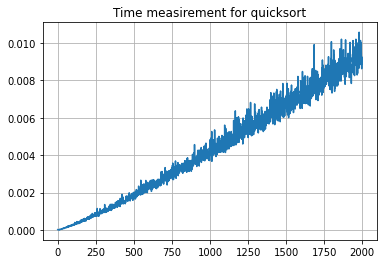

In [24]:
times = []
for i in range(1, 2001):
    v = np.random.rand(i)
    start_time = time.time()
    quicksort(v)
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measirement for quicksort")
plt.grid(True)
plt.show()

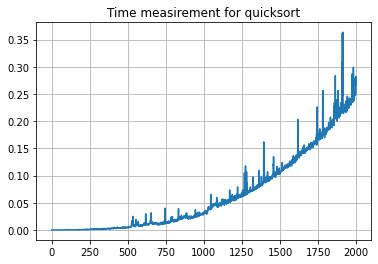

In [25]:
times = []
for i in range(1, 2001):
    matrix_a = np.random.rand(i, i)
    matrix_b = np.random.rand(i, i)
    start_time = time.time()
    matrix_a @ matrix_b
    times.append(time.time() - start_time)

plt.plot(times)
plt.title("Time measirement for quicksort")
plt.grid(True)
plt.show()